# On Deep Learning-Based Channel Decoding

If you want to cite this notebook, please use the following bibtext entry:

    @article{nn-decoding,
      title={On Deep Learning-Based Channel Decoding},
      author={Tobias Gruber and
              Sebastian Cammerer and
              Jakob Hoydis and
              Stephan ten Brink}
      journal={CoRR}
      year={2017}
      url= {http://arxiv.org/abs/1701.07738}
    }

Running this example requires Keras installed with the Theano backend. For GPU support nvidia-docker is required. A Dockerfile is provided to employ this setup quickly.

Our simulation setup was inspired by material from http://radioml.org.


In [16]:
# !pip install tensorflow
# TensorFlow 是一个用于深度学习的开源库

In [135]:
import numpy as np #  Python 的一个科学计算库，提供了高性能的多维数组对象及相应工具
from tensorflow.keras.models import Sequential # 这是构建神经网络模型的一种简单方式，层按顺序排列
from tensorflow.keras.layers import Dense, Lambda #  Dense（全连接层）和 Lambda（自定义层）
from tensorflow.keras import backend as K # 提供了执行低级操作（如张量乘法）的能力
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt # 用于数据可视化,设置 Jupyter Notebook 以内联方式显示图表
%matplotlib inline

# Parameters

In [136]:
k = 8                       # 信息位
N = 16                      # 码长
n = int(np.log2(N))
train_SNR_Eb = 1            # 训练信噪比 Eb/No

nb_epoch = 2**16            # 训练的轮数
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # 定义网络中每层的节点数的列表
batch_size = 2**k            # 用于计算梯度的批量大小
LLR = False                # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'          # adam优化器
loss = 'mse'                # or 'binary_crossentropy' 损失函数

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N) # Es/N0(dB)=Eb/N0(dB)+10log10(k),k = R*log2(2)(bpsk调制)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))) # AWGN的噪声标准差
# 带dB单位的是对数比值，不带dB单位的是线性比值，即直接比
# Es/N0 (dB) = 10 lg(Es/N0)  ，左边是dB单位，右边是无单位，这就是两者转换的公式
# AWGN噪声方差 sigma^2 = N0 / 2
# 这里我们假设单位符号能量Es = 1，则sigma^2 = 1 / [2 * (Es/N0)]，这里的要线性比值（无单位）

# Define NN model

In [137]:
def modulateBPSK(x):
    # BPSK调制
    return -2*x +1;

def addNoise(x, sigma):
    # 添加高斯噪声
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def ber(y_true, y_pred):
    # 计算BER
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    # 用于组合多个层创建一个序贯（Sequential）模型
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    # 计算对数似然比
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    # 一个自定义的度量函数，用于计算预测和真实标签之间的错误数
#     return K.sum(K.not_equal(y_true, K.round(y_pred)))
    errors_tensor = K.cast(K.not_equal(y_true, K.round(y_pred)), 'float32')
    return K.sum(errors_tensor)


Lambda 层是一个灵活的层，允许你在模型中应用任意的表达式或函数作为一个层的操作。这使得你可以快速地将简单的、自定义的函数集成到Keras的序贯（Sequential）或函数式（Functional）模型中。

In [138]:
# # Define modulator
# modulator_layers = [Lambda(modulateBPSK, 
#                           input_shape=(N,), output_shape=return_output_shape, name="modulator")]
# modulator = compose_model(modulator_layers) # 将这些层组合成一个完整的模型
# modulator.compile(optimizer=optimizer, loss=loss) # 调用 compile 方法配置模型的训练过程，包括设置优化器和损失函数

# # Define noise
# noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
#                        input_shape=(N,), output_shape=return_output_shape, name="noise")]
# noise = compose_model(noise_layers)
# noise.compile(optimizer=optimizer, loss=loss)

# # Define LLR
# llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
#                      input_shape=(N,), output_shape=return_output_shape, name="LLR")]
# llr = compose_model(llr_layers)
# llr.compile(optimizer=optimizer, loss=loss)

# Define decoder 
decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
for i in range(1,len(design)):
    decoder_layers.append(Dense(design[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

# # Define model
# if LLR:
#     model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
# else:
#     model_layers = modulator_layers + noise_layers + decoder_layers
# model = compose_model(model_layers)
# model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
# model = decoder

# Data Generation

In [139]:
def half_adder(a,b):
    # 半加器，用于执行两个比特的加法
    s = a ^ b # 异或操作，得到求和结果
    c = a & b # 与操作，得到进位结果
    return s,c

def full_adder(a,b,c):
    # 完整加法器的实现，处理两个比特的加法和进位
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n] # 极化
            i=i+2*n
        n=2*n
    return x

def G_N(n):
    G = np.array([[1, 0], [1, 1]])  # 初始生成矩阵 G2
    for _ in range(1, n):
        N = int(2 ** _)  # 确保N是整数
        G_up = np.hstack([np.hstack([G[:, j:j+1], np.zeros((N, 1), dtype=int)]) for j in range(N)])
        G_down = np.hstack([np.hstack([G[:, j:j+1], G[:, j:j+1]]) for j in range(N)])
        G = np.vstack([G_up, G_down])
    return G

def MAP(codebook, y, G, A):
    num = len(codebook)
    s = 1 - 2 * codebook
    mse = np.zeros(num)
    for i in range(num):
        mse[i] = np.sum((s[i, :] - y) ** 2)
    index = np.argmin(mse)
    u = np.mod(np.dot(codebook[index, :], G), 2)
    return u[A]

def MAP_batch(codebook, y_batch, G, A):
    map_d_batch = []
    for y in y_batch:  # 对每个样本进行MAP译码
        map_d = MAP(codebook, y, G, A)
        map_d_batch.append(map_d)
    return np.array(map_d_batch)


In [140]:
# 创建所有可能的信息位，从全0到全1，每一个都生成了
d = np.zeros((2**k,k),dtype=bool)
for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

# 创建所有可能的码字集（码本）
if code == 'polar':   
    
    A = polar_design_awgn(N, k, design_snr_dB=0)  # SNR(dB) = 0得出来的信息索引
    x = np.zeros((2**k, N),dtype=bool) 
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i]) # 编码

elif code == 'random':
    
    np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

codebook = x
G = G_N(n)

# Train Neural Network

In [144]:
decoder.summary() # 打印模型的摘要，包括每层的名称、形状和参数数量

# BPSK
s_train = 1 - 2*x

for i in range(0, int(nb_epoch)):
    # AWGN
    y_train = s_train + train_sigma * np.random.standard_normal(s_train.shape)
    # y_train为输入，map_d为map译码结果，为训练的目标
    map_d = MAP_batch(codebook, y_train, G, A)
#     print("y_train shape:", y_train.shape)
#     print("map_d shape:", map_d.shape)
    history = decoder.fit(y_train, map_d, batch_size=batch_size, epochs=1, verbose=0, shuffle=True) # 模型训练




# x为输入
# d为真值/标签
# batch_size指定了每次训练迭代中使用的样本数量，每训练一个batch就更新一轮参数
# epochs指定了整个训练数据集将被遍历的次数
# verbose=0 表示不输出任何训练过程中的信息，1 或 2 会显示更多信息
# shuffle=True：在每个训练周期开始时，是否随机打乱输入样本的顺序。这通常有助于提高模型的泛化能力和避免特定的训练顺序所导致的偏差

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               2176      
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12776 (49.91 KB)
Trainable params: 12776 (49.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(256, 8)


KeyboardInterrupt: 

# Test NN

In [109]:
test_batch = 1000  
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

In [110]:
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros(len(sigmas),dtype=int)
nb_bits = np.zeros(len(sigmas),dtype=int)

for i in range(0,len(sigmas)):

    for ii in range(0,np.round(num_words/test_batch).astype(int)):
        
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch,k)) 

        # Encoder
        if code == 'polar':
            x_test = np.zeros((test_batch, N),dtype=bool)
            u_test = np.zeros((test_batch, N),dtype=bool)
            u_test[:,A] = d_test

            for iii in range(0,test_batch):
                x_test[iii] = polar_transform_iter(u_test[iii])

        elif code == 'random':
            x_test = np.zeros((test_batch, N),dtype=bool)
            for iii in range(0,test_batch):
                x_test[iii] = x[bin2int(d_test[iii])]

        # Modulator (BPSK)
        s_test = -2*x_test + 1

        # Channel (AWGN)
        y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape) # sigma*N(0, 1) = N(0, sigma^2)

        if LLR:
            y_test = 2*y_test/(sigmas[i]**2)

        # Decoder
#         map_d = MAP_batch(codebook, y_test, G, A)
        nb_errors[i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
        nb_bits[i] += d_test.size

# Load MAP

In [111]:
# result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=',')
# sigmas_map = result_map[:,0]
# nb_bits_map = result_map[:,1]
# nb_errors_map = result_map[:,2]

# Plot Bit-Error-Rate

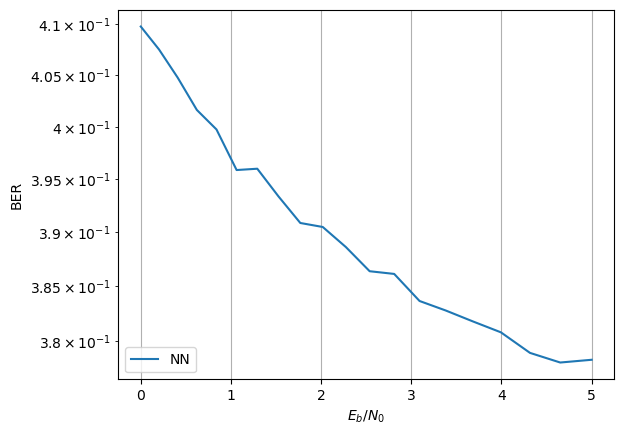

In [112]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors/nb_bits)
legend.append('NN') 

# plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
# legend.append('MAP') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.show()

In [113]:
nnd_ber = nb_errors/nb_bits
nnd_ber

array([0.40975 , 0.4075  , 0.40475 , 0.401625, 0.39975 , 0.395875,
       0.396   , 0.393375, 0.390875, 0.3905  , 0.388625, 0.386375,
       0.386125, 0.383625, 0.38275 , 0.38175 , 0.38075 , 0.378875,
       0.378   , 0.37825 ])

In [114]:
def to_matlab_array_format(data):
    return 'nnd_ber = [' + ', '.join(map(str, data)) + '];'

In [115]:
to_matlab_array_format(nnd_ber)

'nnd_ber = [0.40975, 0.4075, 0.40475, 0.401625, 0.39975, 0.395875, 0.396, 0.393375, 0.390875, 0.3905, 0.388625, 0.386375, 0.386125, 0.383625, 0.38275, 0.38175, 0.38075, 0.378875, 0.378, 0.37825];'

In [113]:
0-10*np.log10(k/N)

3.010299956639812

In [78]:
my_test = np.random.randint(0,2,size=(num_words,k)) 
x_test = np.zeros((num_words, N),dtype=bool)
u_test = np.zeros((num_words, N),dtype=bool)
u_test[:,A] = my_test

for iii in range(0,num_words):
    x_test[iii] = polar_transform_iter(u_test[iii])
s_test = -2*x_test + 1

# Channel (AWGN)
y_test = s_test + sigmas[10]*np.random.standard_normal(s_test.shape) # sigma*N(0, 1) = N(0, sigma^2)

if LLR:
    y_test = 2*y_test/(sigmas[10]**2)
    

In [95]:
sigmas[10]

0.7696533290475521

In [80]:
my_errors = 0
for i in range(0,1000): 
    temp = y_test[i].reshape(1, -1)
#     temp = MAP(codebook, y_test[i], G, A).reshape(1, -1)
    u_hat = decoder.predict(temp, verbose=0)
    my_errors += errors(my_test[i], u_hat).numpy()


In [84]:
my_errors

3071.0

In [85]:
my_errors / (1000 * 8)

0.383875

In [86]:
u_hat

array([[2.6862158e-03, 9.9990666e-01, 3.4084523e-28, 6.5986482e-05,
        4.7580204e-26, 9.5839132e-06, 1.0000000e+00, 1.8676095e-05]],
      dtype=float32)